# DCGAN with CelebA
- Generative Adversarial Nets : https://arxiv.org/pdf/1406.2661.pdf

## 1. Data

```script
chmod +x download.sh
./download.sh
unzip -q CelebA_128crop_FD.zip?dl=0 -d ./data/
```

## 2. Import Libs

In [1]:
import torch, os
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image
from torchvision.utils import make_grid
from torch.autograd import Variable
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

## 3. Hyperparameters

In [2]:
lr = 0.0002
max_epoch = 20
batch_size = 32
z_dim = 100
image_size = 64
g_conv_dim = 64
d_conv_dim = 64
log_step = 100
sample_step = 500
sample_num = 32
IMAGE_PATH = './data/CelebA/'
SAMPLE_PATH = './celebA_DCGAN_results/output/'

if not os.path.exists(SAMPLE_PATH):
    os.makedirs(SAMPLE_PATH)

## 4. Load Data

In [3]:
transform = transforms.Compose([
    transforms.Scale(image_size),
    # transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = ImageFolder(IMAGE_PATH, transform)
data_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, num_workers=8, drop_last=True)

## 5. Model Define

In [4]:
def conv(ch_in, ch_out, k_size, stride=2, pad=1, bn=True):
    layers = []
    layers.append(nn.Conv2d(ch_in, ch_out, k_size, stride, pad))
    if bn:
        layers.append(nn.BatchNorm2d(ch_out))
    return nn.Sequential(*layers)


class Discriminator(nn.Module):
    def __init__(self, image_size=128, conv_dim=64):
        super(Discriminator, self).__init__()
        self.conv1 = conv(3, conv_dim, 4, bn=False)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4)
        self.fc = conv(conv_dim*8, 1, int(image_size/16), 1, 0, False)
        
    def forward(self, x):                                 # if image_size is 64, output shape is below
        out = F.leaky_relu(self.conv1(x), 0.05)    # (?, 64, 32, 32)     
        out = F.leaky_relu(self.conv2(out), 0.05) # (?, 128, 16, 16)
        out = F.leaky_relu(self.conv3(out), 0.05) # (?, 256, 8, 8)
        out = F.leaky_relu(self.conv4(out), 0.05) # (?, 512, 4, 4)
        out = F.sigmoid(self.fc(out)).squeeze()
        return out
    
D = Discriminator(image_size)
D.cuda()

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
  )
  (fc): Sequential(
    (0): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
  )
)

In [5]:
def deconv(ch_in, ch_out, k_size, stride=2, pad=1, bn=True):
    layers = []
    layers.append(nn.ConvTranspose2d(ch_in, ch_out, k_size, stride, pad))
    if bn:
        layers.append(nn.BatchNorm2d(ch_out))
    return nn.Sequential(*layers)

class Generator(nn.Module):
    def __init__(self, z_dim=256, image_size=128, conv_dim=64):
        super(Generator, self).__init__()
        self.fc = deconv(z_dim, conv_dim*8, int(image_size/16), 1, 0, bn=False)
        self.deconv1 = deconv(conv_dim*8, conv_dim*4, 4)
        self.deconv2 = deconv(conv_dim*4, conv_dim*2, 4)
        self.deconv3 = deconv(conv_dim*2, conv_dim, 4)
        self.deconv4 = deconv(conv_dim, 3, 4, bn=False)
        
    def forward(self, z):
        z = z.view(z.size(0), z.size(1), 1, 1)
        out = self.fc(z)
        out = F.leaky_relu(self.deconv1(out), 0.05)
        out = F.leaky_relu(self.deconv2(out), 0.05)
        out = F.leaky_relu(self.deconv3(out), 0.05)
        out = F.tanh(self.deconv4(out))
        return out
    
G = Generator(z_dim, image_size, g_conv_dim)
G.cuda()

Generator(
  (fc): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
  )
  (deconv1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  )
  (deconv2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  )
  (deconv3): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  )
  (deconv4): Sequential(
    (0): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)

## 6. Loss func & Optimizer

In [6]:
criterion = nn.BCELoss().cuda()
d_optimizer = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))

## 7. etc

In [7]:
# denormalization : [-1,1] -> [0,1]
# normalization : [0,1] -> [-1,1]
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

## 8. Train

In [8]:
try:
    G.load_state_dict(torch.load('./celebA_DCGAN_results/generator.pkl'))
    D.load_state_dict(torch.load('./celebA_DCGAN_results/discriminator.pkl'))
    print("\n-------------model restored-------------\n")
except:
    print("\n-------------model not restored-------------\n")
    pass


-------------model not restored-------------



In [9]:
total_batch = len(data_loader.dataset)//batch_size
fixed_z = Variable(torch.randn(sample_num, z_dim)).cuda()
for epoch in range(max_epoch):
    for i, (images, labels) in enumerate(data_loader):
        # Build mini-batch dataset
        image = Variable(images).cuda()
        # Create the labels which are later used as input for the BCE loss
        real_labels = Variable(torch.ones(batch_size)).cuda()
        fake_labels = Variable(torch.zeros(batch_size)).cuda()
        
        #============ train the discriminator ============
        # Compute BCE_loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
        # Second term of the loss is always zero since real_labels = 1
        outputs = D(image)
        d_loss_real = criterion(outputs, real_labels) # BCE
        real_score = outputs
        
        # compute BCE_loss using fake images
        z = Variable(torch.randn(batch_size, z_dim)).cuda()
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels) #BCE
        fake_score = outputs
        
        # Backprob + Optimize
        d_loss = d_loss_real + d_loss_fake
        D.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        #============ train the generator ============
        # Compute loss with fake images
        z = Variable(torch.randn(batch_size, z_dim)).cuda()
        fake_images = G(z)
        outputs = D(fake_images)
        
        # We train G to maximize log(D(G(z))) instead of minimizing log(1-D(G(z)))
        # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
        g_loss = criterion(outputs, real_labels) # BCE
        
        # Backprob + Optimize
        D.zero_grad()
        G.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
        if(i+1)%log_step == 0:
            print("Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, g_loss: %.4f, D(x): %.2f, D(G(z)): %.2f"%(
            epoch, max_epoch, i+1, total_batch, d_loss.data[0], g_loss.data[0], real_score.data.mean(), fake_score.data.mean()))
        
        if(i+1)%sample_step == 0:
            fake_images = G(fixed_z)
            torchvision.utils.save_image(denorm(fake_images.data), os.path.join(SAMPLE_PATH, 'fake_samples-%d-%d.png')%(
            epoch+1, i+1), nrow=8)
            
torch.save(G.state_dict(), './celebA_DCGAN_results/generator.pkl')
torch.save(D.state_dict(), './celebA_DCGAN_results/discriminator.pkl')

Epoch [0/20], Step[100/4882], d_loss: 0.4043, g_loss: 3.3087, D(x): 0.81, D(G(z)): 0.15
Epoch [0/20], Step[200/4882], d_loss: 0.8602, g_loss: 1.2173, D(x): 0.63, D(G(z)): 0.30
Epoch [0/20], Step[300/4882], d_loss: 1.1541, g_loss: 1.3509, D(x): 0.41, D(G(z)): 0.14
Epoch [0/20], Step[400/4882], d_loss: 1.4278, g_loss: 1.6775, D(x): 0.61, D(G(z)): 0.50
Epoch [0/20], Step[500/4882], d_loss: 0.8921, g_loss: 1.5641, D(x): 0.65, D(G(z)): 0.34
Epoch [0/20], Step[600/4882], d_loss: 1.0378, g_loss: 1.1814, D(x): 0.51, D(G(z)): 0.23
Epoch [0/20], Step[700/4882], d_loss: 0.8828, g_loss: 1.4524, D(x): 0.66, D(G(z)): 0.35
Epoch [0/20], Step[800/4882], d_loss: 1.0353, g_loss: 1.1516, D(x): 0.63, D(G(z)): 0.40
Epoch [0/20], Step[900/4882], d_loss: 1.1427, g_loss: 2.5174, D(x): 0.81, D(G(z)): 0.57
Epoch [0/20], Step[1000/4882], d_loss: 0.8142, g_loss: 1.5138, D(x): 0.71, D(G(z)): 0.35
Epoch [0/20], Step[1100/4882], d_loss: 0.8816, g_loss: 1.4427, D(x): 0.60, D(G(z)): 0.26
Epoch [0/20], Step[1200/4882],

Epoch [1/20], Step[4600/4882], d_loss: 0.2193, g_loss: 2.2144, D(x): 0.87, D(G(z)): 0.04
Epoch [1/20], Step[4700/4882], d_loss: 0.8533, g_loss: 2.0053, D(x): 0.55, D(G(z)): 0.05
Epoch [1/20], Step[4800/4882], d_loss: 0.3210, g_loss: 3.1729, D(x): 0.83, D(G(z)): 0.06
Epoch [2/20], Step[100/4882], d_loss: 0.1847, g_loss: 4.0662, D(x): 0.94, D(G(z)): 0.09
Epoch [2/20], Step[200/4882], d_loss: 0.7628, g_loss: 1.4600, D(x): 0.57, D(G(z)): 0.04
Epoch [2/20], Step[300/4882], d_loss: 0.3728, g_loss: 2.8996, D(x): 0.85, D(G(z)): 0.15
Epoch [2/20], Step[400/4882], d_loss: 0.1730, g_loss: 3.6084, D(x): 0.95, D(G(z)): 0.10
Epoch [2/20], Step[500/4882], d_loss: 0.9289, g_loss: 1.1081, D(x): 0.50, D(G(z)): 0.04
Epoch [2/20], Step[600/4882], d_loss: 0.5077, g_loss: 4.7228, D(x): 0.85, D(G(z)): 0.26
Epoch [2/20], Step[700/4882], d_loss: 0.2239, g_loss: 3.9470, D(x): 0.89, D(G(z)): 0.08
Epoch [2/20], Step[800/4882], d_loss: 0.2490, g_loss: 3.7212, D(x): 0.92, D(G(z)): 0.14
Epoch [2/20], Step[900/4882],

Epoch [3/20], Step[4300/4882], d_loss: 0.0465, g_loss: 4.5099, D(x): 0.99, D(G(z)): 0.04
Epoch [3/20], Step[4400/4882], d_loss: 0.3245, g_loss: 2.4914, D(x): 0.83, D(G(z)): 0.06
Epoch [3/20], Step[4500/4882], d_loss: 0.1648, g_loss: 4.8968, D(x): 0.99, D(G(z)): 0.12
Epoch [3/20], Step[4600/4882], d_loss: 0.1427, g_loss: 5.7157, D(x): 0.96, D(G(z)): 0.09
Epoch [3/20], Step[4700/4882], d_loss: 0.1313, g_loss: 5.5430, D(x): 0.97, D(G(z)): 0.09
Epoch [3/20], Step[4800/4882], d_loss: 0.1781, g_loss: 3.0205, D(x): 0.88, D(G(z)): 0.04
Epoch [4/20], Step[100/4882], d_loss: 0.1974, g_loss: 5.5347, D(x): 0.93, D(G(z)): 0.08
Epoch [4/20], Step[200/4882], d_loss: 0.1753, g_loss: 4.9404, D(x): 0.92, D(G(z)): 0.05
Epoch [4/20], Step[300/4882], d_loss: 0.0596, g_loss: 5.6793, D(x): 0.98, D(G(z)): 0.03
Epoch [4/20], Step[400/4882], d_loss: 0.2092, g_loss: 5.8819, D(x): 1.00, D(G(z)): 0.16
Epoch [4/20], Step[500/4882], d_loss: 0.2695, g_loss: 4.0704, D(x): 0.82, D(G(z)): 0.02
Epoch [4/20], Step[600/488

Epoch [5/20], Step[4000/4882], d_loss: 0.0650, g_loss: 2.0398, D(x): 1.00, D(G(z)): 0.06
Epoch [5/20], Step[4100/4882], d_loss: 0.0555, g_loss: 4.7944, D(x): 0.96, D(G(z)): 0.01
Epoch [5/20], Step[4200/4882], d_loss: 0.1035, g_loss: 5.5447, D(x): 0.92, D(G(z)): 0.01
Epoch [5/20], Step[4300/4882], d_loss: 0.0802, g_loss: 4.7497, D(x): 0.94, D(G(z)): 0.01
Epoch [5/20], Step[4400/4882], d_loss: 0.0996, g_loss: 5.6893, D(x): 0.95, D(G(z)): 0.04
Epoch [5/20], Step[4500/4882], d_loss: 0.0660, g_loss: 4.9643, D(x): 0.99, D(G(z)): 0.04
Epoch [5/20], Step[4600/4882], d_loss: 0.0782, g_loss: 5.7133, D(x): 0.95, D(G(z)): 0.02
Epoch [5/20], Step[4700/4882], d_loss: 0.1342, g_loss: 3.6588, D(x): 0.92, D(G(z)): 0.03
Epoch [5/20], Step[4800/4882], d_loss: 0.0383, g_loss: 4.6623, D(x): 0.99, D(G(z)): 0.03
Epoch [6/20], Step[100/4882], d_loss: 0.1067, g_loss: 4.5991, D(x): 0.99, D(G(z)): 0.06
Epoch [6/20], Step[200/4882], d_loss: 0.0409, g_loss: 5.6198, D(x): 1.00, D(G(z)): 0.04
Epoch [6/20], Step[300/

Epoch [7/20], Step[3700/4882], d_loss: 0.0278, g_loss: 7.1599, D(x): 0.99, D(G(z)): 0.01
Epoch [7/20], Step[3800/4882], d_loss: 0.0844, g_loss: 7.0823, D(x): 0.93, D(G(z)): 0.00
Epoch [7/20], Step[3900/4882], d_loss: 0.0043, g_loss: 8.1218, D(x): 1.00, D(G(z)): 0.00
Epoch [7/20], Step[4000/4882], d_loss: 0.0621, g_loss: 4.1613, D(x): 0.98, D(G(z)): 0.03
Epoch [7/20], Step[4100/4882], d_loss: 0.0357, g_loss: 6.3163, D(x): 0.98, D(G(z)): 0.01
Epoch [7/20], Step[4200/4882], d_loss: 0.0815, g_loss: 6.2460, D(x): 0.99, D(G(z)): 0.06
Epoch [7/20], Step[4300/4882], d_loss: 0.0853, g_loss: 6.2263, D(x): 0.98, D(G(z)): 0.06
Epoch [7/20], Step[4400/4882], d_loss: 0.0473, g_loss: 6.5343, D(x): 0.97, D(G(z)): 0.01
Epoch [7/20], Step[4500/4882], d_loss: 0.1110, g_loss: 4.8183, D(x): 0.91, D(G(z)): 0.00
Epoch [7/20], Step[4600/4882], d_loss: 0.1827, g_loss: 8.7887, D(x): 0.88, D(G(z)): 0.01
Epoch [7/20], Step[4700/4882], d_loss: 0.0223, g_loss: 7.2127, D(x): 0.99, D(G(z)): 0.01
Epoch [7/20], Step[48

Epoch [9/20], Step[3400/4882], d_loss: 0.0382, g_loss: 5.9160, D(x): 0.98, D(G(z)): 0.02
Epoch [9/20], Step[3500/4882], d_loss: 0.0391, g_loss: 6.1917, D(x): 0.99, D(G(z)): 0.03
Epoch [9/20], Step[3600/4882], d_loss: 0.0226, g_loss: 6.5762, D(x): 1.00, D(G(z)): 0.02
Epoch [9/20], Step[3700/4882], d_loss: 0.0933, g_loss: 5.9119, D(x): 0.93, D(G(z)): 0.00
Epoch [9/20], Step[3800/4882], d_loss: 0.0154, g_loss: 4.9518, D(x): 1.00, D(G(z)): 0.01
Epoch [9/20], Step[3900/4882], d_loss: 0.0208, g_loss: 7.6902, D(x): 0.99, D(G(z)): 0.01
Epoch [9/20], Step[4000/4882], d_loss: 0.1143, g_loss: 7.9656, D(x): 0.91, D(G(z)): 0.00
Epoch [9/20], Step[4100/4882], d_loss: 0.0288, g_loss: 7.6950, D(x): 0.99, D(G(z)): 0.01
Epoch [9/20], Step[4200/4882], d_loss: 0.0120, g_loss: 8.7171, D(x): 0.99, D(G(z)): 0.00
Epoch [9/20], Step[4300/4882], d_loss: 0.0514, g_loss: 6.8669, D(x): 0.99, D(G(z)): 0.03
Epoch [9/20], Step[4400/4882], d_loss: 0.0076, g_loss: 7.2888, D(x): 1.00, D(G(z)): 0.00
Epoch [9/20], Step[45

Epoch [11/20], Step[3000/4882], d_loss: 0.0331, g_loss: 5.9481, D(x): 1.00, D(G(z)): 0.03
Epoch [11/20], Step[3100/4882], d_loss: 0.0283, g_loss: 6.5760, D(x): 0.98, D(G(z)): 0.01
Epoch [11/20], Step[3200/4882], d_loss: 0.0253, g_loss: 5.5430, D(x): 1.00, D(G(z)): 0.02
Epoch [11/20], Step[3300/4882], d_loss: 0.0170, g_loss: 5.5724, D(x): 1.00, D(G(z)): 0.01
Epoch [11/20], Step[3400/4882], d_loss: 0.0609, g_loss: 6.9227, D(x): 0.99, D(G(z)): 0.04
Epoch [11/20], Step[3500/4882], d_loss: 0.0990, g_loss: 3.1079, D(x): 1.00, D(G(z)): 0.08
Epoch [11/20], Step[3600/4882], d_loss: 0.0747, g_loss: 7.1879, D(x): 0.95, D(G(z)): 0.01
Epoch [11/20], Step[3700/4882], d_loss: 0.0175, g_loss: 5.7654, D(x): 1.00, D(G(z)): 0.01
Epoch [11/20], Step[3800/4882], d_loss: 0.0389, g_loss: 7.4662, D(x): 0.97, D(G(z)): 0.00
Epoch [11/20], Step[3900/4882], d_loss: 0.0367, g_loss: 6.1397, D(x): 0.97, D(G(z)): 0.00
Epoch [11/20], Step[4000/4882], d_loss: 0.0183, g_loss: 7.0809, D(x): 0.98, D(G(z)): 0.00
Epoch [11/

Epoch [13/20], Step[2600/4882], d_loss: 0.2764, g_loss: 7.4522, D(x): 1.00, D(G(z)): 0.18
Epoch [13/20], Step[2700/4882], d_loss: 0.0936, g_loss: 6.8588, D(x): 1.00, D(G(z)): 0.07
Epoch [13/20], Step[2800/4882], d_loss: 0.0820, g_loss: 9.0602, D(x): 1.00, D(G(z)): 0.04
Epoch [13/20], Step[2900/4882], d_loss: 0.1438, g_loss: 7.0421, D(x): 1.00, D(G(z)): 0.06
Epoch [13/20], Step[3000/4882], d_loss: 0.0562, g_loss: 7.5130, D(x): 1.00, D(G(z)): 0.05
Epoch [13/20], Step[3100/4882], d_loss: 0.0139, g_loss: 6.6278, D(x): 1.00, D(G(z)): 0.01
Epoch [13/20], Step[3200/4882], d_loss: 0.0838, g_loss: 6.3286, D(x): 1.00, D(G(z)): 0.07
Epoch [13/20], Step[3300/4882], d_loss: 0.0531, g_loss: 6.5467, D(x): 1.00, D(G(z)): 0.05
Epoch [13/20], Step[3400/4882], d_loss: 0.1463, g_loss: 5.9800, D(x): 0.96, D(G(z)): 0.08
Epoch [13/20], Step[3500/4882], d_loss: 0.0131, g_loss: 8.0876, D(x): 0.99, D(G(z)): 0.00
Epoch [13/20], Step[3600/4882], d_loss: 0.2078, g_loss: 7.1072, D(x): 0.99, D(G(z)): 0.15
Epoch [13/

Epoch [15/20], Step[2200/4882], d_loss: 0.0503, g_loss: 6.0262, D(x): 0.97, D(G(z)): 0.02
Epoch [15/20], Step[2300/4882], d_loss: 0.0164, g_loss: 7.4630, D(x): 0.99, D(G(z)): 0.01
Epoch [15/20], Step[2400/4882], d_loss: 0.0850, g_loss: 10.3247, D(x): 1.00, D(G(z)): 0.07
Epoch [15/20], Step[2500/4882], d_loss: 0.0451, g_loss: 6.6100, D(x): 0.96, D(G(z)): 0.00
Epoch [15/20], Step[2600/4882], d_loss: 0.0071, g_loss: 7.5538, D(x): 1.00, D(G(z)): 0.00
Epoch [15/20], Step[2700/4882], d_loss: 0.3868, g_loss: 9.4495, D(x): 1.00, D(G(z)): 0.26
Epoch [15/20], Step[2800/4882], d_loss: 0.0114, g_loss: 6.2112, D(x): 1.00, D(G(z)): 0.01
Epoch [15/20], Step[2900/4882], d_loss: 0.0018, g_loss: 7.2753, D(x): 1.00, D(G(z)): 0.00
Epoch [15/20], Step[3000/4882], d_loss: 0.0057, g_loss: 9.6621, D(x): 1.00, D(G(z)): 0.00
Epoch [15/20], Step[3100/4882], d_loss: 0.0061, g_loss: 7.8878, D(x): 1.00, D(G(z)): 0.00
Epoch [15/20], Step[3200/4882], d_loss: 0.0435, g_loss: 9.0524, D(x): 1.00, D(G(z)): 0.04
Epoch [15

Epoch [17/20], Step[1800/4882], d_loss: 0.0710, g_loss: 5.9088, D(x): 0.95, D(G(z)): 0.00
Epoch [17/20], Step[1900/4882], d_loss: 0.0568, g_loss: 7.0631, D(x): 1.00, D(G(z)): 0.05
Epoch [17/20], Step[2000/4882], d_loss: 0.0095, g_loss: 8.0315, D(x): 1.00, D(G(z)): 0.01
Epoch [17/20], Step[2100/4882], d_loss: 0.0202, g_loss: 4.4706, D(x): 1.00, D(G(z)): 0.02
Epoch [17/20], Step[2200/4882], d_loss: 0.0017, g_loss: 7.2598, D(x): 1.00, D(G(z)): 0.00
Epoch [17/20], Step[2300/4882], d_loss: 0.0336, g_loss: 7.2129, D(x): 1.00, D(G(z)): 0.02
Epoch [17/20], Step[2400/4882], d_loss: 0.0321, g_loss: 5.5742, D(x): 0.99, D(G(z)): 0.02
Epoch [17/20], Step[2500/4882], d_loss: 0.1646, g_loss: 8.6089, D(x): 1.00, D(G(z)): 0.12
Epoch [17/20], Step[2600/4882], d_loss: 0.0090, g_loss: 8.3269, D(x): 1.00, D(G(z)): 0.01
Epoch [17/20], Step[2700/4882], d_loss: 0.0052, g_loss: 5.6381, D(x): 1.00, D(G(z)): 0.00
Epoch [17/20], Step[2800/4882], d_loss: 0.0439, g_loss: 8.3058, D(x): 1.00, D(G(z)): 0.04
Epoch [17/

Epoch [19/20], Step[1400/4882], d_loss: 0.0464, g_loss: 7.7720, D(x): 0.98, D(G(z)): 0.02
Epoch [19/20], Step[1500/4882], d_loss: 0.0161, g_loss: 9.2958, D(x): 1.00, D(G(z)): 0.01
Epoch [19/20], Step[1600/4882], d_loss: 0.0624, g_loss: 5.8712, D(x): 0.96, D(G(z)): 0.00
Epoch [19/20], Step[1700/4882], d_loss: 0.0128, g_loss: 7.3855, D(x): 0.99, D(G(z)): 0.01
Epoch [19/20], Step[1800/4882], d_loss: 0.0085, g_loss: 9.2722, D(x): 0.99, D(G(z)): 0.00
Epoch [19/20], Step[1900/4882], d_loss: 0.0303, g_loss: 7.8636, D(x): 0.98, D(G(z)): 0.01
Epoch [19/20], Step[2000/4882], d_loss: 0.0113, g_loss: 9.3488, D(x): 1.00, D(G(z)): 0.01
Epoch [19/20], Step[2100/4882], d_loss: 0.0635, g_loss: 7.5580, D(x): 0.99, D(G(z)): 0.04
Epoch [19/20], Step[2200/4882], d_loss: 0.0082, g_loss: 7.2027, D(x): 1.00, D(G(z)): 0.01
Epoch [19/20], Step[2300/4882], d_loss: 0.0078, g_loss: 6.8520, D(x): 0.99, D(G(z)): 0.00
Epoch [19/20], Step[2400/4882], d_loss: 0.0032, g_loss: 6.7220, D(x): 1.00, D(G(z)): 0.00
Epoch [19/

## 9. test

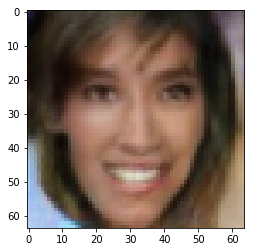

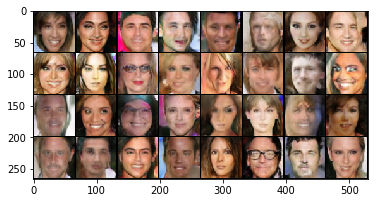

In [10]:
fixed_z = Variable(torch.randn(sample_num, z_dim)).cuda()
fake_images = G(fixed_z)
plt.imshow(denorm(fake_images[0].cpu().permute(1, 2, 0).data).numpy())
plt.show()

plt.imshow(make_grid(denorm(fake_images).data.cpu()).permute(1, 2, 0).numpy())
plt.show()

## 10. img2gif

In [11]:
import imageio

images = []
for epoch in range(max_epoch):
    for i in range(total_batch):
        if(i+1)%sample_step == 0:
            img_name = './celebA_DCGAN_results/output/fake_samples-' + str(epoch + 1) + '-' + str(i + 1) + '.png'
            images.append(imageio.imread(img_name))
            print("epoch : {}, step : {}".format(epoch+1, i+1))
imageio.mimsave('./celebA_DCGAN_results/dcgan_celebA_generation_animation.gif', images, fps=5)

epoch : 1, step : 500
epoch : 1, step : 1000
epoch : 1, step : 1500
epoch : 1, step : 2000
epoch : 1, step : 2500
epoch : 1, step : 3000
epoch : 1, step : 3500
epoch : 1, step : 4000
epoch : 1, step : 4500
epoch : 2, step : 500
epoch : 2, step : 1000
epoch : 2, step : 1500
epoch : 2, step : 2000
epoch : 2, step : 2500
epoch : 2, step : 3000
epoch : 2, step : 3500
epoch : 2, step : 4000
epoch : 2, step : 4500
epoch : 3, step : 500
epoch : 3, step : 1000
epoch : 3, step : 1500
epoch : 3, step : 2000
epoch : 3, step : 2500
epoch : 3, step : 3000
epoch : 3, step : 3500
epoch : 3, step : 4000
epoch : 3, step : 4500
epoch : 4, step : 500
epoch : 4, step : 1000
epoch : 4, step : 1500
epoch : 4, step : 2000
epoch : 4, step : 2500
epoch : 4, step : 3000
epoch : 4, step : 3500
epoch : 4, step : 4000
epoch : 4, step : 4500
epoch : 5, step : 500
epoch : 5, step : 1000
epoch : 5, step : 1500
epoch : 5, step : 2000
epoch : 5, step : 2500
epoch : 5, step : 3000
epoch : 5, step : 3500
epoch : 5, step 